<center><h1>Mini Project 2</h1></center>
<br>
<center><font size="5">Name - Spandan Patil</font></center>
<br>
<center><font size="4">Cycle Power Plant Data</font></center>

## 1. Combined Cycle Power Plant Data Set

### (a) Download Data

Package imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from itertools import combinations

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

Get the Cycle Power Plant Data Set

In [2]:
# Here i am import the dataset and loading it into pandas dataframe.
dataSet = pd.read_excel("../data/CCPP/Folds5x2_pp.xlsx", engine="openpyxl")


### (b) Exploring the data

#### i. rows and columns

In [3]:
# As we can see below there are 9568 rows and 5 columns of which first 4 our the input features and last PE column is our output feature. All the values in each column are of type float64 and there is no null value present in the dataset. Each row represent a data point for hourly average ambient variables Temperature (AT), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) and the net hourly electrical energy output (PE)
dataSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


#### ii. pairwise scatterplots of all the varianbles

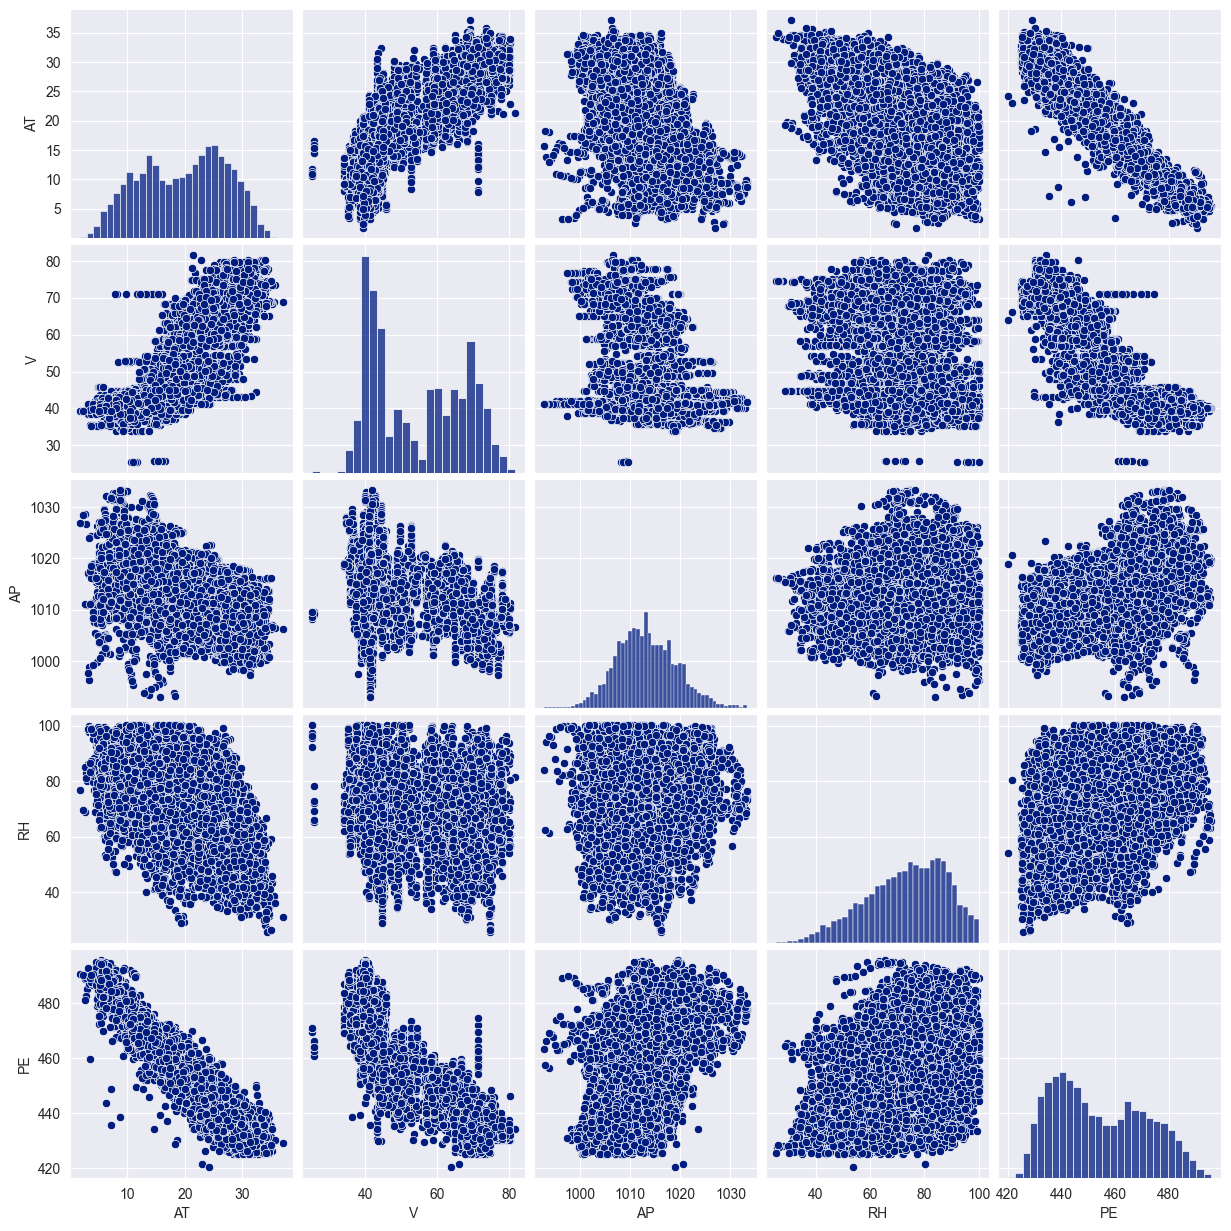

In [4]:
# Here i am plotting the pairwise scatterplot for all the features (AT, V, AP, RH, PE)
sns.set_style("darkgrid")
sns.set_palette("dark") 
sns.pairplot(dataSet, kind='scatter')
plt.show()

By observing the pairwise scatterplot, we can conclude that the following: <br>
<ul>
    <li>AT is strongly inversely proportional (strong negative correlation) to the PE and it, and it seems like bimodal distribution having 2 peaks.</li>
    <li>V is also inversely proportional (negative correlation) to PE. and it seems like mutlimodal distribution having many peaks and is irregular.</li>
    <li>AP is slightly proportional (weak positive correlation) to PE, and it follows normal distribution </li>
    <li>RH is also very slightly proportional (very weak positive correlation) to PE, and it is rightly skewed distribution.</li>
    <li>PE seems like a left skewed bimodal distribution with 2 peaks. </li>
</ul>


#### iii. mean, the median, range, first and third quartiles, and interquartile ranges

In [5]:
# Here i am creating a pandas dataframe having the statistical values for each of the features.
stat_table = pd.DataFrame({
    "Mean": dataSet.mean(), 
    "Median": dataSet.median(), 
    "Range": (dataSet.max() - dataSet.min()), 
    "First Quartile": dataSet.quantile(0.25),
    "Third Quartile": dataSet.quantile(0.75),
    "InterQuartile Range": (dataSet.quantile(0.75) - dataSet.quantile(0.25))})

stat_table

,Mean,Median,Range,First Quartile,Third Quartile,InterQuartile Range
AT,19.651231,20.345,35.30,13.5100,25.72,12.2100
V,54.305804,52.080,56.20,41.7400,66.54,24.8000
AP,1013.259078,1012.940,40.41,1009.1000,1017.26,8.1600
RH,73.308978,74.975,74.60,63.3275,84.83,21.5025
PE,454.365009,451.550,75.50,439.7500,468.43,28.6800


### (c) Simple Linear Regression

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                 8.510e+04
Date:                Thu, 13 Feb 2025   Prob (F-statistic):               0.00
Time:                        21:00:14   Log-Likelihood:                -29756.
No. Observations:                9568   AIC:                         5.952e+04
Df Residuals:                    9566   BIC:                         5.953e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        497.0341      0.156   3177.280      0.0

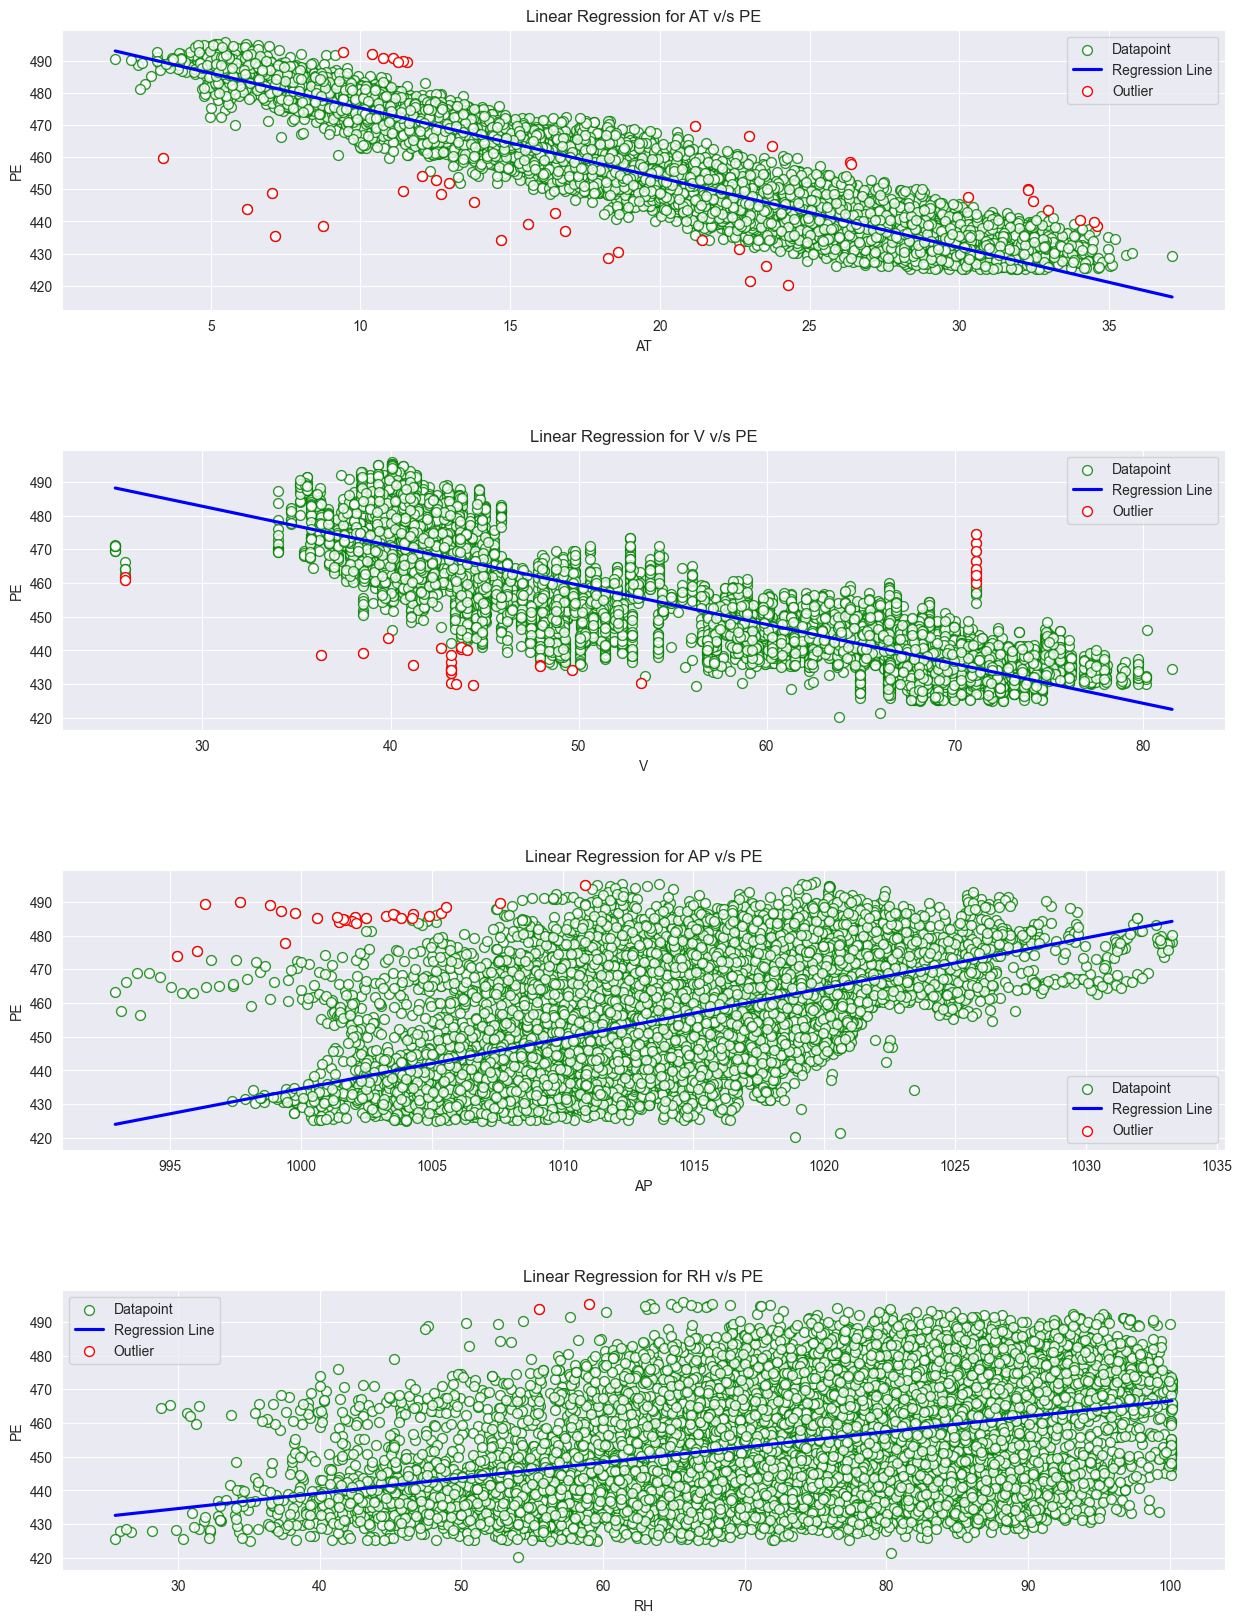

,Predictor,R²,P_value
0,AT,0.898948,0.e+00
1,V,0.756518,0.e+00
2,AP,0.268769,0.e+00
3,RH,0.151939,0.e+00


In [6]:
# Here i am setting the input and out features for the linear regression model.
in_features = dataSet.columns[:-1]
out_feature = dataSet.columns[-1]

# Creating a dataframe to store the R squared and p-value for each of the predictors.
res = pd.DataFrame(columns=["Predictor", "R²", "P_value"])

# Store the co-efficients for each of the predictors in this list.
uni_coeffs = []

# Create a group plot of the regression line for all the predictors.
fig, axes = plt.subplots(len(in_features), figsize=(15, 20))

# Iterating over all the input predictors
for idx, pred_name in enumerate(in_features):
    # Getting all the datapoints for that predictor
    pred = dataSet[pred_name]
    # Add a constant intercept value in case that the impact of predictor is zero.
    pred = sm.add_constant(pred)

    # Fitting the predictors datapoints in a linear regression model for getting the prediction PE.
    lr_model = sm.OLS(dataSet[out_feature], pred).fit()

    # Getting the residual value of each of the data point which is (actual value - predicted value)
    diff = lr_model.resid
    
    # Setting threshold for outliers (3 standard deviations away from the mean)
    threshold = 3 * np.std(diff)
    
    # Storing the indices of the outliers.
    outliers = np.abs(diff) > threshold

    # Getting the p_value for the predictor and formating it to be presented in a scientific notation format like 2.1e^-10
    p_val = np.format_float_scientific(lr_model.pvalues[pred_name], precision=15)

    # Getting the R squared value for the predictor.
    r_sq = lr_model.rsquared

    # Storing the coefficient of the predictor
    uni_coeffs.append(lr_model.params[pred_name])

    # Adding the R square and p value to our summary dataframe.
    res.loc[len(res)] = [pred_name, r_sq, p_val]
    print(lr_model.summary())
    print("")
    print("")

    # Plotting regression line for the predictor with the outlier colored in red, while the non-outlier datapoints in green
    sns.regplot(x=pred_name, y=out_feature, data=dataSet, line_kws={'color' : 'Blue'},  scatter_kws={'color': 'white', 'edgecolor': "green", "s": 50}, ci=None, ax=axes[idx])
    axes[idx].scatter(dataSet[pred_name][outliers], dataSet[out_feature][outliers], color='White', label='Outliers', s=50, edgecolor='red')
    axes[idx].set_title(f"Linear Regression for {pred_name} v/s PE")
    axes[idx].set_xlabel(pred_name)
    axes[idx].set_ylabel("PE")
    axes[idx].legend(["Datapoint", "Regression Line", "Outlier"])

plt.subplots_adjust(hspace=0.5)
plt.show()
res



Observing the P-values of the all the predictor, we can conclude that all the predictors are statistical significant. And based on the R squared values we can say that the model fit AT and V predictor well, but not so for the AP and RH as they have a low R squared value. And through the plot we can see the Outlier present for the datapoint of each of the predictor. I would remove the outlier present in the AT as they are scatter all around and deviate significantly from the rest, thus, seems to be genuine outliers. For rest of the predictors there are not so much deviatation of the outlier from the general data points, so we need to be careful before removing them.

### (d) Multiple Regression

In [7]:
# Add a constant intercept value in case that the impact of predictors is zero.
X = sm.add_constant(dataSet[in_features])

# Fitting the predictors datapoints in a linear regression model for getting the prediction PE.
multi_model = sm.OLS(dataSet[out_feature], X).fit()

# Storing the coefficient of the predictors
multi_coeffs = multi_model.params[1:]

# Displaying the summary of the model.
print(multi_model.summary())


                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Thu, 13 Feb 2025   Prob (F-statistic):               0.00
Time:                        21:00:15   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.6093      9.749     46.634      0.0

As we can see for all the predictor (AT, V, AP, RH) the P_value is very small nearing 0, Hence, we can reject the Null Hypothesis for all the predictors.

### (e) 1c Compare to 1d

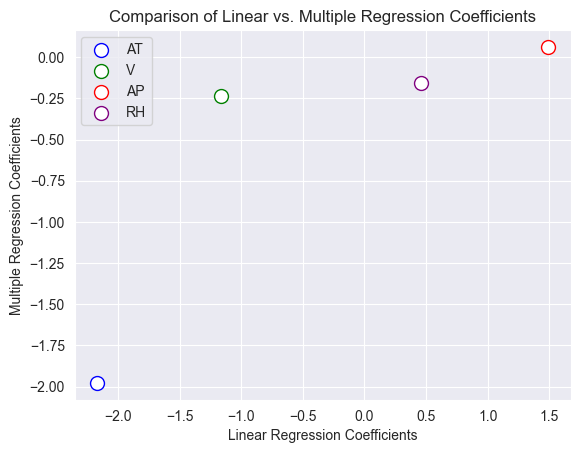

In [8]:
# Setting a distinct colors for each predictor
colors = ['blue', 'green', 'red', 'purple']

# Iterating over each of the predictors univariant coefficient and multivariant cofficient and the color and plotting them.
for pred_name, uni_val, multi_val, color in zip(in_features, uni_coeffs, multi_coeffs, colors):
    plt.scatter(uni_val, multi_val, color='white', edgecolors=color, s=100, label=pred_name)

# Labels and title
plt.xlabel("Linear Regression Coefficients")
plt.ylabel("Multiple Regression Coefficients")
plt.title("Comparison of Linear vs. Multiple Regression Coefficients")
plt.legend()

plt.show()

The following key observation we can make from the change in coefficients in the linear univariant regression and multiple regression:<br>

<ul>
    <li>In the multiple regression we can see that the magnitude of coefficient(impact) of all the predictor has decrease, since, the influence of other predictors are taken in consideration in multiple regression compares to linear univariant regression. </li>
    <li>We can observe that the impact of AT and V has weaken from -2.1 to -1.9 and -1.1 to -0.2 respectively, while the impact of AP is also negible going from 1.48 to 0.06</li>
    <li> For the RH predictor the sign has changed from +ve to -ve, meaning it reduces the PE insted of increasing it. This would be due to its correlation with other predictor, which lead to misleading results in the linear univariant regression.</li>

</ul>

### (f) Nonlinear Association

In [9]:
# Here i am setting the input and out features for the linear regression model.
in_features = dataSet.columns[:-1]
out_feature = dataSet.columns[-1]

# Creating a dataframe to store the p-value for each of the predictor, predictor squared and predictor cubed.
res = pd.DataFrame(columns=["Predictor Name", "P_value (Predictor)" ,"P_value (Predictor²)", "P_value (Predictor³)"])

# Iterating over all the input predictors
for idx, pred_name in enumerate(in_features):
    # Getting all the datapoints for that predictor
    pred = dataSet[pred_name]
    # Creating the predictor squared and cubed datapoints
    pred_cubic = np.column_stack((pred, pred**2, pred**3))
    # Add a constant intercept value in case that the impact of predictor is zero.
    pred_cubic = sm.add_constant(pred_cubic)
    # Fitting the predictors datapoints in a linear regression model for getting the prediction PE.
    lr_model = sm.OLS(dataSet[out_feature], pred_cubic).fit()

    # Getting the p-value for predictor, predictor squared and predictor cubed
    p_val = lr_model.pvalues[1]
    p_val2 = lr_model.pvalues[2]
    p_val3 =lr_model.pvalues[3]
    
    # Adding the p values to our summary dataframe.
    res.loc[len(res)] = [pred_name, p_val, p_val2, p_val3]
    print(lr_model.summary())
    print("")
    print("")
res




                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 3.299e+04
Date:                Thu, 13 Feb 2025   Prob (F-statistic):               0.00
Time:                        21:00:15   Log-Likelihood:                -29101.
No. Observations:                9568   AIC:                         5.821e+04
Df Residuals:                    9564   BIC:                         5.824e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        492.7281      0.673    732.248      0.0

,Predictor Name,P_value (Predictor),P_value (Predictor²),P_value (Predictor³)
0,AT,7.898147e-07,8.833045e-73,3.652185e-110
1,V,2.526589e-05,7.684969e-01,1.373489e-02
2,AP,4.502735e-17,3.666705e-17,8.264146e-18
3,RH,3.772510e-04,9.395430e-06,1.440279e-05


From the above table we can see that for AT, AP, RH there is evidence of non-linear association since the sqaure and cubic predictors are statistically significant, while for V, we can observce the cubic predictor is statistically significant while the square is not.

### (g) Interactions of Predictors

In [10]:
# Making a copy of our dataset to add the interaction terms to the copy.
dataSetPair = dataSet.copy()
# List of store the column names of all the interaction terms.
pair_terms = list()
# Iterting over all the predictors in pairs and creating the interaction terms.
for p1, p2 in combinations(in_features, 2):
    pair_col = f"{p1}_&_{p2}"
    # Creating the datapoint for the interaction term.
    dataSetPair[pair_col] = dataSetPair[p1] * dataSetPair[p2]  
    pair_terms.append(pair_col)

# Creating a new list having all the input features including the interaction terms.
pair_in_features = list(in_features) + pair_terms
# Getting all the datapoints for that predictor
pair_in_features_data = dataSetPair[pair_in_features]

# Add a constant intercept value in case that the impact of predictor is zero.
pair_in_features_data = sm.add_constant(pair_in_features_data) 

# Fitting the predictors datapoints in a linear regression model for getting the prediction PE.
pair_model = sm.OLS(dataSetPair[out_feature], pair_in_features_data).fit()

# Print summary of our model
print(pair_model.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Thu, 13 Feb 2025   Prob (F-statistic):               0.00
Time:                        21:00:15   Log-Likelihood:                -27548.
No. Observations:                9568   AIC:                         5.512e+04
Df Residuals:                    9557   BIC:                         5.520e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        685.7825     78.640      8.721      0.0

According to the above p_values we can conclude that only the following pair terms are statistically significant:<br>
<ul>
    <li>AT and V</li>
    <li>AT and RH</li>
    <li>V and AP</li>
    <li>AP and RH</li>
</ul>

### (h) Improvement

#### Model with only the predictors

In [11]:
# Performing the train and test split for our dataset.
X_train, X_test, y_train, y_test = train_test_split(dataSet[in_features], dataSet[out_feature], test_size=0.3)

In [12]:
# Add a constant intercept value in case that the impact of predictor is zero.
X_train = sm.add_constant(X_train) 
# Fitting the predictors datapoints in a linear regression model for getting the prediction PE.
multi_model = sm.OLS(y_train, X_train).fit()

# Getting the prediction for the train and test dataset.
y_train_pred = multi_model.predict(X_train)
y_test_pred = multi_model.predict(sm.add_constant(X_test))

# Calculate MSE for the train and test sets.
train_mse_multi_model = mean_squared_error(y_train, y_train_pred)
test_mse_multi_model = mean_squared_error(y_test, y_test_pred)

print(f"Train MSE for Multiple Regression Model: {train_mse_multi_model}")
print(f"Test MSE for Multiple Regression Model: {test_mse_multi_model}")

Train MSE for Multiple Regression Model: 21.272464606749036
Test MSE for Multiple Regression Model: 19.619423465695466


#### Model with all the predictors, pair interaction terms, quadratic non-linear terms.

In [13]:
# Making a copy of our dataset to add all the predictors, interaction terms and the non-linear terms.
dataSetFull = dataSetPair.copy()
# Variable to store all the input features name.
full_in_features = pair_in_features.copy()
for pred in in_features:
    full_in_features.append(f"{pred}^2")
    # Creating the data points for the Quadratic terms for each predictor.
    dataSetFull[f"{pred}^2"] = dataSetFull[pred] ** 2  # Quadratic term

In [14]:
# Performing the train and test split for our dataset.
X_train, X_test, y_train, y_test = train_test_split(dataSetFull[full_in_features], dataSetFull[out_feature], test_size=0.3)

In [15]:
# Add a constant intercept value in case that the impact of predictor is zero.
X_train = sm.add_constant(X_train)
# Fitting the predictors datapoints in a linear regression model for getting the prediction PE.
full_model = sm.OLS(y_train, X_train).fit()

# Getting the indices of significant predictor whose p-value is greater than 0.05. 
sig_pred = full_model.pvalues[full_model.pvalues < 0.05].index
# Dropping the constant intercept term which we added.
X_train = X_train[sig_pred.drop('const')]
X_test = X_test[sig_pred.drop('const')]

# Add a constant intercept value in case that the impact of predictor is zero.
X_train = sm.add_constant(X_train)  
# Fitting the predictors datapoints in a linear regression model for getting the prediction PE.
full_model = sm.OLS(y_train, X_train).fit()

# Getting the prediction for the train and test dataset.
y_train_pred = full_model.predict(X_train)
y_test_pred = full_model.predict(sm.add_constant(X_test))

# Calculate MSE for the train and test sets.
train_mse_full_model = mean_squared_error(y_train, y_train_pred)
test_mse_full_model = mean_squared_error(y_test, y_test_pred)

print(f"Train MSE for Full Regression Model: {train_mse_full_model}")
print(f"Test MSE for Full Regression Model: {test_mse_full_model}")

Train MSE for Full Regression Model: 20.378499747670787
Test MSE for Full Regression Model: 19.764483215211534


### (i) KNN

In [16]:
# Performing the train and test split for our dataset.
X_train, X_test, y_train, y_test = train_test_split(dataSet[in_features], dataSet[out_feature], test_size=0.3)

#### Raw Features

In [17]:
# List of all the k values for which we are going to test out Knn Regression.
k_val = [k for k in range(1, 100)]

# A dataframe to store the train and test errors for each of the 1/k values.
train_test_errs = pd.DataFrame(columns=["1/k_value", "train_err", "test_err"])

# Variables to store the Optimal k value and its train_set predictions and test_set predictions
opt_k = None

# Variable to store the current minimum test error seen
min_err = float("inf")

for k in k_val:
    # Creating a Knn Regression object with number of neighbors to consider as k and distance metrics as euclidean, which is same as minkowski metric with p = 2, according the sklearn documentation.
    knn = KNeighborsRegressor(n_neighbors=k,  metric='minkowski', p=2)
    knn.fit(X_train, y_train)
    
    train_y_pred = knn.predict(X_train)
    test_y_pred = knn.predict(X_test)

    # Calculating the training and testing mean squared errors.
    train_err =  mean_squared_error(y_train, train_y_pred)
    test_err =  mean_squared_error(y_test, test_y_pred)

    # Adding the train and test error for the current k to our summary dataframe.
    train_test_errs.loc[len(train_test_errs)] = [(1/k), train_err, test_err]

    # If we have found a smaller test error then update the optimal k value and its respective test_err, train predictions and test predicitions.
    if min_err > test_err or (min_err >= test_err and opt_k == 1):
        opt_k = k
        min_err = test_err
    

The optimal value of k is 6 with Mean Squared Error as 16.33


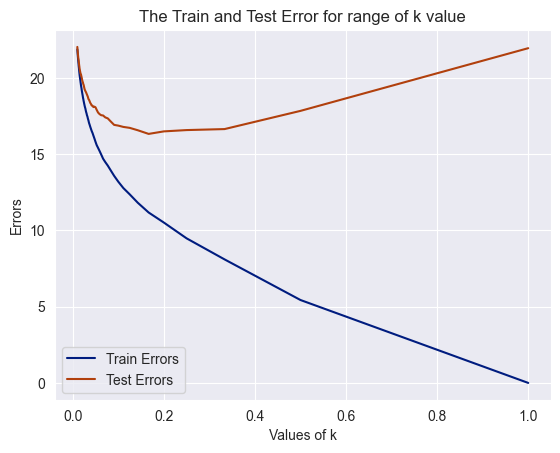

In [18]:
print(f"The optimal value of k is {opt_k} with Mean Squared Error as {min_err:.2f}")
# Plotting the Train and Test errors graph with respect to the different values of k.
plt.title("The Train and Test Error for range of k value")
plt.plot(train_test_errs["1/k_value"], train_test_errs["train_err"], label="Train Errors")
plt.plot(train_test_errs["1/k_value"], train_test_errs["test_err"], label="Test Errors")
plt.xlabel("Values of k")
plt.ylabel("Errors")
plt.legend()
plt.show()


#### Normalized Features

In [19]:
# Creating the scaler object to perform noramlization on our predictor datapoints.
minMaxScaler = MinMaxScaler()

# Performing the normalization on the train and test datapoints.
X_train = minMaxScaler.fit_transform(X_train)
X_test = minMaxScaler.transform(X_test)

In [20]:
# List of all the k values for which we are going to test out Knn Regression.
k_val = [k for k in range(1, 100)]

# A dataframe to store the train and test errors for each of the 1/k values.
train_test_errs = pd.DataFrame(columns=["1/k_value", "train_err", "test_err"])

# Variables to store the Optimal k value and its train_set predictions and test_set predictions
opt_k = None

# Variable to store the current minimum test error seen
min_err = float("inf")

for k in k_val:
    # Creating a Knn Regression object with number of neighbors to consider as k and distance metrics as euclidean, which is same as minkowski metric with p = 2, according the sklearn documentation.
    knn = KNeighborsRegressor(n_neighbors=k,  metric='minkowski', p=2)
    knn.fit(X_train, y_train)
    
    train_y_pred = knn.predict(X_train)
    test_y_pred = knn.predict(X_test)

    # Calculating the training and testing mean squared errors.
    train_err =  mean_squared_error(y_train, train_y_pred)
    test_err =  mean_squared_error(y_test, test_y_pred)

    # Adding the train and test error for the current k to our summary dataframe.
    train_test_errs.loc[len(train_test_errs)] = [(1/k), train_err, test_err]

    # If we have found a smaller test error then update the optimal k value and its respective test_err, train predictions and test predicitions.
    if min_err > test_err or (min_err >= test_err and opt_k == 1):
        opt_k = k
        min_err = test_err
    

The optimal value of k is 6 with Mean Squared Error as 14.98


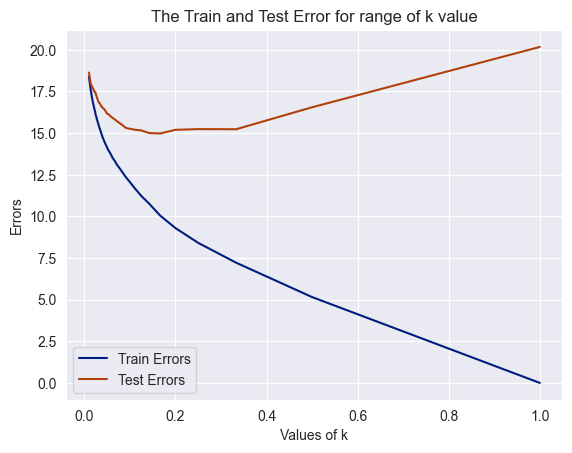

In [21]:
print(f"The optimal value of k is {opt_k} with Mean Squared Error as {min_err:.2f}")
# Plotting the Train and Test errors graph with respect to the different values of k.
plt.title("The Train and Test Error for range of k value")
plt.plot(train_test_errs["1/k_value"], train_test_errs["train_err"], label="Train Errors")
plt.plot(train_test_errs["1/k_value"], train_test_errs["test_err"], label="Test Errors")
plt.xlabel("Values of k")
plt.ylabel("Errors")
plt.legend()
plt.show()


### (j ) Compare KNN and Linear

For the linear regression model, we got the smallest MSE as 19.76 for the Full model which was having all the significant predictors, predictors square, and interaction terms.<br><br>
For the KNearestNeighbor Regression Model, we got the smallest MSE as 14.98 for the normalized data with k value as 6.
<br><br>
Thus, we can conclude that the KNN Regression model was a better fit for this dataset. And we can say that there as dataset might have complex, nonlinear relationships that the linear model can't fully capture, but since KNN considers the local relations of the dataset, it is able to perform better for these nonlinear relations. 

## 2. ISLR: 2.4.1

### (a) The sample size n is extremely large, and the number of predictors p is small.

In this case, the flexible model will perform better, as due to large size of n, it can effectively capture the complex patterns present in the data, without running into the issue of overfitting, since, there is enough data for generalization. Also, the small number of predictors p reduces the risk of overfitting even more.

### (b) The number of predictors p is extremely large, and the number of observations n is small.

In this case, the inflexible model will perform better, since due to small n and a large number of predictors, the flexible model will tend to overfit the data, captures noise instead of the underlying patterns. But since the inflexible model imposes a structure on the data, it reduces the risk of overfitting.

### (c) The relationship between the predictors and response is highly non-linear.

In this case, the flexible model will preform better since, it will be able capture the complex non-linear relationships of the predictors better compared to the inflexible model which perform very poorly for capturing non-linear patterns.

### (d) The variance of the error terms, i.e. $σ^2$ = Var(ε), is extremely high.

In this case, the inflexible model will perform better, since high variance of error terms means that there is a lot of noise in the data, which will lead the flexible model to overfit and result in poor generalization.

## 3. ISLR: 2.4.7

### (a) Compute the Euclidean distance between each observation and the test point, X1 = X2 = X3 = 0.

| Obs no. | Distance Formula | Distance |
|---------|------------------|------------|
|1 | $\sqrt{(0-0)^2 + (3-0)^2 + (0-0)^2}$ | 3.0 |
|2 | $\sqrt{(2-0)^2 + (0-0)^2 + (0-0)^2} $ | 2.0 |
|3 | $\sqrt{(0-0)^2 + (1-0)^2 + (3-0)^2}$ | 3.16 |
|4 | $\sqrt{(0-0)^2 + (1-0)^2 + (2-0)^2} $ | 2.24 |
|5 | $\sqrt{(-1-0)^2 + (0-0)^2 + (1-0)^2}$  | 1.41 |
|6 | $\sqrt{(1-0)^2 + (1-0)^2 + (1-0)^2} $ | 1.73  |

### (b) What is our prediction with K = 1? Why?

For K = 1, our prediction is Green, since the observation point 5 has the minimum distance and its label is Green.

### (c) What is our prediction with K = 3? Why?

For K = 3, our prediction is Red, since the 3 closest observation points are 5 (Green), 6 (Red), 2 (Red). Thus, taking the majority class of the 3, we choose Red as our prediction.

### (d) If the Bayes decision boundary in this problem is highly non-linear, then would we expect the best value for K to be large or small? Why?

In this case, we would expect the best value of K to be small. Since, a small value of k allows us to capture the local complex non-linear patterns in the vicinity of our data point, compared to a large value of k which will make it less flexible and failing to capture the local complexity.